In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

## Two rooms grid

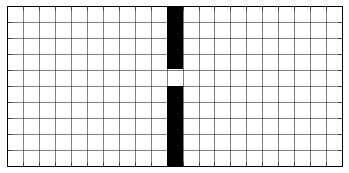

In [11]:
grid = np.zeros((10,21))
grid[:,10] = -1
grid[4,10] =  0
GOAL = (9,20)
WESTregion_LIMIT = 10 #not included 
plt.imshow(grid, cmap='gray', interpolation='nearest', extent = [0,21,0,10])
ax = plt.gca();
ax.set_xticks(np.arange(0,21, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.grid(color='black', which = 'major', linestyle='-')
plt.show()

In [12]:
from collections import defaultdict
from utils import getTransitions_and_Rewards

In [13]:
"""
actions  = [up,down,right,left]
"""
trans, r = getTransitions_and_Rewards(grid, GOAL)
gamma = 0.9
p_uniform = 0.1

## Q-learning

In [14]:
import sys
from IPython.display import clear_output
from random import shuffle

In [15]:
#with random ties breaking (and not just taking first action, otherwise I go into loop becuase rewards are 0 for non-term)
def greedyAction(state, Q):
    actions = range(4)
    shuffle(actions)
    
    bestAct = -1
    qMax = -np.inf
    
    for a in actions:        
        if Q[state][a] > qMax:
            bestAct = a
            qMax    = Q[state][a]
    
    return bestAct
        
    

In [32]:
westRegion = [(i,j) for i in range(10) for j in range(WESTregion_LIMIT)]
eps = 0.1
alpha = 0.05
nbEpisodes = 80


Steps_per_run = np.zeros((30,80))
seeds = np.random.randint(1000, size=30)

for run in range(30):  
    np.random.seed(seeds[run])
    Q = defaultdict(lambda: [0,0,0,0])
    clear_output()
    print run
    sys.stdout.flush()
    for episode in range(80):
        state = westRegion[np.random.choice(range(len(westRegion)))]
        nbSteps = 0
        while (state != GOAL):
            nbSteps +=1

            #choose A from S
            if np.random.binomial(1,eps):
                a = np.random.choice(range(4))
            else:
                a = greedyAction(state, Q)            

            #take A and observe S'        
            if (np.random.binomial(1, p_uniform)):
                nextState = trans[state][np.random.choice(range(4))]
            else:
                nextState = trans[state][a]

            #and R
            R = r[nextState]

            #greedy action from S'
            next_greedy_a = greedyAction(nextState, Q)
            
            Q[state][a]  += alpha * (R + gamma * Q[nextState][next_greedy_a] - Q[state][a]) 

            state = nextState
        
        Steps_per_run[run][episode] = nbSteps

29


In [17]:
avg_steps_per_episode = Steps_per_run.mean(axis=0)

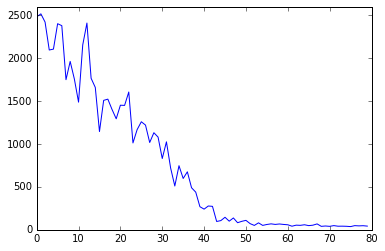

In [18]:
plt.plot(range(80), avg_steps_per_episode)
plt.ylim(0,2600)
plt.show()

## Options discovery

In [19]:
novelty     = lambda s: 1.0/np.sqrt(nbVisits[s])

set_novelty = lambda S: 1.0/np.sqrt(nbVisits[np.array([s[0] for s in S]), np.array([s[1] for s in S])].mean())  

def rel_novelty(prev_sequence, succ_sequence):
    return float(set_novelty(succ_sequence)) / set_novelty(prev_sequence)

In [20]:
def isTarget(state):    
    n1 = sum(scores[state])
    n  = len(scores[state])
    rhs= np.log(float((1-q))/(1-p)) / np.log(float(p*(1-q))/q*(1-p)) + 1.0/n * (np.log(float(costRatio * priorRatio))/ np.log(float(p*(1-q)) / (q*(1-p))))
    if (float(n1)/n > rhs):
        return True
    return False

In [21]:
def generateOption(I, subGoal):
    #Option new value function and Subgoal specific reward
    Q_o = defaultdict(lambda: [0,0,0,0])
    r_o = np.zeros((10,21))
        
    for row in range(10):
        for col in range(21):
            state = (row,col)
            if state in I:
                r_o[state] = -1
            elif state==subGoal:
                r_o[state] =  50
            else:
                r_o[state] = -50
                
   
    for e in range(10):
        state = random.sample(I,1)[0]
        while (state != subGoal and state in I):

            #choose A from S
            if np.random.binomial(1,eps):
                a = np.random.choice(range(4))
            else:
                a = greedyAction(state, Q_o)            

            #take A and observe S'        
            if (np.random.binomial(1, p_uniform)):
                nextState = trans[state][np.random.choice(range(4))]
            else:
                nextState = trans[state][a]

            #and R
            R = r_o[nextState]

            #greedy action from S'
            next_greedy_a = greedyAction(nextState, Q_o)
            
            Q_o[state][a]  += alpha * (R + gamma * Q_o[nextState][next_greedy_a] - Q_o[state][a]) 

            state = nextState
 
    for state in I:
        Options[state].append((I,Q_o, subGoal, r_o))
        Q[state].append(0) #new Q_value of the option
        
def executeOption(state, optIdx):
    option = Options[state][optIdx]
    I      = option[0]
    Q_o    = option[1]
    subGoal= option[2]
    r_o    = option[3]
    
    discSum = 0
    nbSteps = 0   
  
    initState = state
    while state in I and state != subGoal:        
        #choose A from S
        if np.random.binomial(1,eps):
            a = np.random.choice(range(4))
        else:
            a = greedyAction(state, Q_o)            

        #take A and observe S'        
        if (np.random.binomial(1, p_uniform)):
            nextState = trans[state][np.random.choice(range(4))]
        else:
            nextState = trans[state][a]

        #and R
        R = r_o[nextState]

        #greedy action from S'
        next_greedy_a = greedyAction(nextState, Q_o)

        Q_o[state][a]  += alpha * (R + gamma * Q_o[nextState][next_greedy_a] - Q_o[state][a]) 

        state = nextState    
        
        discSum += r[nextState]*gamma**(nbSteps)
        state = nextState
        nbSteps +=1
    
    Q[initState][optIdx] += (discSum + gamma**(nbSteps)*Q[state][np.argmax(Q[state])])
    #raw_input("Pausa")    
    return (state)

In [22]:
import random

In [63]:
""" Classification parameters"""
t_RN = 2
p = 0.0712
q = 0.0056
costRatio = 100
priorRatio = 100
ln = 7
lo = 10 #nb states to include in the Inititation state


westRegion = [(i,j) for i in range(10) for j in range(WESTregion_LIMIT)]
eps = 0.1
alpha = 0.05
nbEpisodes = 80

nbSubGoal_tot = np.zeros((10,21))

Steps_per_run = np.zeros((30,80))
goals_per_run = []

for run in range(30):    
    np.random.seed(seeds[run])
    Q = defaultdict(lambda: [0,0,0,0]) 
    scores = defaultdict(list)
    nbSubGoal = np.zeros((10,21))    
    
   
    Options = defaultdict(lambda: [0,0,0,0])
    prec_VisitSum = 0
    succ_VisitSum = 0
    for episode in range(80): 
        clear_output()  
        print "Run: ",run
        print "Episode:", episode
        sys.stdout.flush()
        #RESET visit counts
        nbVisits = np.zeros((10,21))        
        states_visited = []        
        
        state = westRegion[np.random.choice(range(len(westRegion)))]
        nbSteps = 0
        
        states_visited.append(state)
        nbVisits[state] +=1  
       
        while (state != GOAL):
            nbSteps +=1
            #choose A from S
            if np.random.binomial(1,eps):
                a = np.random.choice(range(len(Q[state])))
            else:
                a = greedyAction(state, Q)            
            
            
            if a<4:
                #take A and observe S'        
                if (np.random.binomial(1, p_uniform)):
                    nextState = trans[state][np.random.choice(range(4))]
                else:
                    nextState = trans[state][a]

                #and R
                R = r[nextState]

                #greedy action from S'
                next_greedy_a = greedyAction(nextState, Q)

                Q[state][a]  += alpha * (R + gamma * Q[nextState][next_greedy_a] - Q[state][a]) 
               
            
            else:                
                nextState = executeOption(state, a)
            """
            keep track of states visited to compute relative novelty scores
            """
            if nextState != state:
                states_visited.append(nextState)                
                nbVisits[nextState]+=1
            
            "Update novelty score of states visited nlag steps before and checkTarget"
            if len(states_visited) >= (2*ln):
                
                prec_seq = states_visited[-2*ln:-ln]
                succ_seq = states_visited[-ln:]
                score = rel_novelty(prec_seq, succ_seq)
                
                state2update = states_visited[-ln]
                
                if score >= t_RN:
                    score =1
                else:
                    score =0
                scores[state2update].append(score)
                
                if isTarget(state2update):
                    nbSubGoal[state2update] +=1
                    nbSubGoal_tot[state2update] += 1
                    """Create Option"""
                    I = set(states_visited[-lo-ln:-ln])
                    generateOption(I, state2update)
                      
            state = nextState
             
        Steps_per_run[run][episode] = nbSteps
    goals_per_run.append((nbSubGoal>0).sum())

Run:  29
Episode: 79


## Subgoal identified in last episode

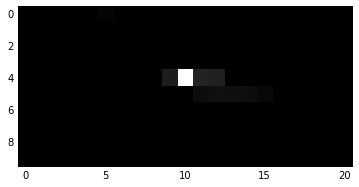

In [26]:
plt.imshow(nbSubGoal, cmap='gray', interpolation='nearest')
plt.show()

## Subgoals identified more often in the 30 runs

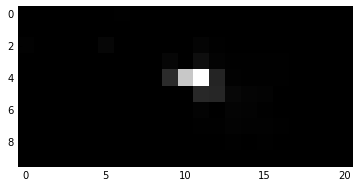

In [61]:
plt.imshow(nbSubGoal_tot, cmap='gray', interpolation='nearest')
plt.savefig('subgoals-2rooms.png', bbox_inches='tight')
plt.show()

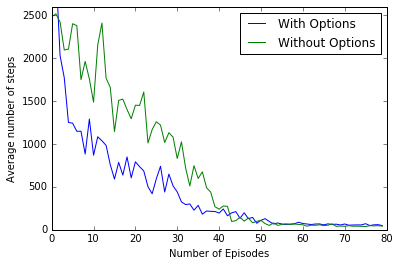

In [64]:
avg_steps_per_episode_Opt = Steps_per_run.mean(axis=0)
plt.plot(range(80), avg_steps_per_episode_Opt, label='With Options')
plt.plot(range(80), avg_steps_per_episode, label = 'Without Options')
plt.xlabel('Number of Episodes')
plt.ylabel('Average number of steps')
plt.ylim(0,2600)
plt.legend()
plt.savefig('comput.png', bbox_inches='tight')
plt.show()